# Train classifiers

If training data has been extracted from the source datasets by running the `00c-extract_training_data_global.ipynb` and `00b-extract_grid_data.ipynb` notebooks, set the `use_extracted_data` variable below to `True` to use this dataset instead of the pre-prepared training data from the [Zenodo repository](https://zenodo.org/record/8157691).

In [1]:
use_extracted_data = False

In [2]:
import os
import time
import warnings
from datetime import timedelta

import cartopy.crs as ccrs
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.gridliner import (
    LATITUDE_FORMATTER,
    LONGITUDE_FORMATTER,
)
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from pulearn.bagging import BaggingPuClassifier
from sklearn.base import clone
from sklearn.cluster import FeatureAgglomeration
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import IterativeImputer
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import (
    Pipeline,
    make_pipeline,
)
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from lib.check_files import check_prepared_data
from lib.feature_selection import (
    dendrogram_from_model,
    distance_threshold_from_model,
)
from lib.misc import (
    format_feature_name,
)
from lib.pu import (
    PU_PARAMS,
    COLUMNS_TO_DROP,
    PRESERVATION_COLUMNS,
    Scorer,
    downsample_unlabelled,
)

# Suppress FutureWarning for some versions of Scikit-learn
%env PYTHONWARNINGS=ignore::FutureWarning

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

env: PYTHONWARNINGS=ignore::FutureWarning


In [3]:
# Random seed for reproducibility
random_seed = 1234

# Number of jobs used to train model
n_jobs = int(os.environ.get("N_JOBS", 8))

# Verbosity level
verbose = int(os.environ.get("VERBOSE", "1"))

# Overwrite pre-existing results
overwrite = bool(int(os.environ.get("OVERWRITE", 1)))
overwrite = False

# Parameters for models
imputer_params = {
    "random_state": random_seed,
    "add_indicator": False,
}
agg_params = {
    "n_clusters": None,  # placeholder
    "distance_threshold": None,  # placeholder
    "compute_distances": True,
}
rf_params = {
    "random_state": random_seed,
    "n_estimators": 50,
    "n_jobs": 1,
}
pu_params = {
    **PU_PARAMS,
    "n_jobs": n_jobs,
    "random_state": random_seed,
    "n_estimators": 50,
}
svm_params = {
    "kernel": "rbf",
    "probability": True,
    "random_state": random_seed,
}
cv_params = {
    "n_splits": 5,
    "n_repeats": 5,
    "random_state": random_seed,
}

# Impute missing values, scale, and combine features
preprocessing = make_pipeline(
    IterativeImputer(**imputer_params),
    RobustScaler(),
    VarianceThreshold(),
    FeatureAgglomeration(**agg_params),
)
cv = RepeatedStratifiedKFold(**cv_params)
scoring = Scorer.adjusted_recall_auc_score

param_grid = {
    "featureagglomeration__n_clusters": [
        5,
        8,
        10,
        12,
        15,
        18,
        20,
        22,
        25,
        28,
        30,
        35,
        40,
    ],
}

In [4]:
# Input/output files
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
data_filename = os.path.join(data_dir, "training_data_global.csv")

output_dir = os.path.join("outputs", "global")
os.makedirs(output_dir, exist_ok=True)
output_deposits = os.path.join(output_dir, "deposits.png")

pu_dir = os.path.join(output_dir, "PU")
os.makedirs(pu_dir, exist_ok=True)
pu_cv_basename = os.path.join(pu_dir, "cv_results")
pu_basename = os.path.join(pu_dir, "classifier")
pu_figures_dir = os.path.join(pu_dir, "feature_agglomeration")
os.makedirs(pu_figures_dir, exist_ok=True)

svm_dir = os.path.join(output_dir, "SVM")
os.makedirs(svm_dir, exist_ok=True)
svm_cv_basename = os.path.join(svm_dir, "cv_results")
svm_basename = os.path.join(svm_dir, "classifier")
svm_figures_dir = os.path.join(svm_dir, "feature_agglomeration")
os.makedirs(svm_figures_dir, exist_ok=True)

In [5]:
data = pd.read_csv(data_filename)

# Equal number of positive and unlabelled samples
negatives = data[data["label"] == "negative"]
tmp = data[data["label"] != "negative"]
tmp_downsampled = downsample_unlabelled(
    tmp,
    random_state=random_seed,
)
combined = pd.concat((tmp_downsampled, negatives))
cleaned = combined.drop(
    columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
    errors="ignore",
)
del tmp, tmp_downsampled

print(combined.groupby(["region", "label"]).size())

region          label     
East Asia       negative         7
                positive         5
                unlabelled      80
North America   negative        45
                positive       255
                unlabelled     116
Other           negative       203
                positive         1
                unlabelled      52
South America   negative      1100
                positive       211
                unlabelled     108
Southeast Asia  negative         4
                positive        55
                unlabelled     134
Tethys          negative        20
                positive        61
                unlabelled      98
dtype: int64


## Plot training data (deposit locations)

In [ ]:
deposits = data[data["label"] == "positive"]

projection = ccrs.Mollweide()
transform = ccrs.PlateCarree()

markers = {
    "North America": "+",
    "South America": ".",
    "Tethys": "*",
    "Southeast Asia": "^",
}
vmin, vmax = 0, 180
cmap = "plasma"
mappable = ScalarMappable(Normalize(vmin, vmax), cmap=cmap)

fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={"projection": projection},
)
ax.set_global()
gl = ax.gridlines(
    draw_labels=False,
    xformatter=LONGITUDE_FORMATTER,
    yformatter=LATITUDE_FORMATTER,
    linestyle="dashed",
    linewidth=0.8,
    alpha=0.5,
    color="grey",
)
cax = fig.add_axes(
    [
        ax.get_position().x0,
        ax.get_position().y0 * 0.3,
        ax.get_position().width,
        ax.get_position().height * 0.05,
    ]
)
for region, marker in markers.items():
    subset = deposits[deposits["region"] == region]
    scat = ax.scatter(
        "present_lon",
        "present_lat",
        c="age (Ma)",
        data=subset,
        marker=marker,
        s=65,
        alpha=0.75,
        transform=transform,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        zorder=1,
        label=region,
    )
ax.coastlines(zorder=0, color="grey", linewidth=0.7)
cbar = fig.colorbar(
    mappable,
    cax=cax,
    orientation="horizontal",
)
cbar.ax.set_xlabel("Deposit age (Ma)", fontsize=12)
cbar.ax.tick_params(labelsize=10)
fig.legend(
    title="Deposits",
    loc=(0.8, 0.68),
    framealpha=0.9,
    fontsize=10,
    title_fontsize=12,
)
fig.savefig(output_deposits, dpi=400, bbox_inches="tight")

## Train the PU models

### Global

#### Perform cross-validation

In [6]:
# Wrangle training data
train_pu = cleaned[cleaned["label"].isin({"positive", "unlabelled"})]
x_pu = train_pu.drop(columns="label")
y_pu = train_pu["label"].replace({"positive": 1, "unlabelled": 0})

if overwrite or not os.path.isfile(pu_cv_basename + ".joblib"):
    pu_model = BaggingPuClassifier(
        RandomForestClassifier(**rf_params),
        **pu_params,
    )
    pu_pipeline = make_pipeline(
        *(clone(preprocessing)),
        pu_model,
    )
    pu_pipeline.set_output(transform="pandas")
    pu_search = GridSearchCV(
        pu_pipeline,
        param_grid=param_grid,
        n_jobs=max((n_jobs // 4, 1)),
        refit=True,
        cv=cv,
        verbose=verbose,
        scoring=scoring,
        return_train_score=False,
    )

    # Train model
    t0 = time.time()
    pu_search.fit(x_pu, y_pu)

    # Save to file
    joblib.dump(pu_search, pu_cv_basename + ".joblib", compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")
else:
    pu_search = joblib.load(pu_cv_basename + ".joblib")

#### Plot CV results

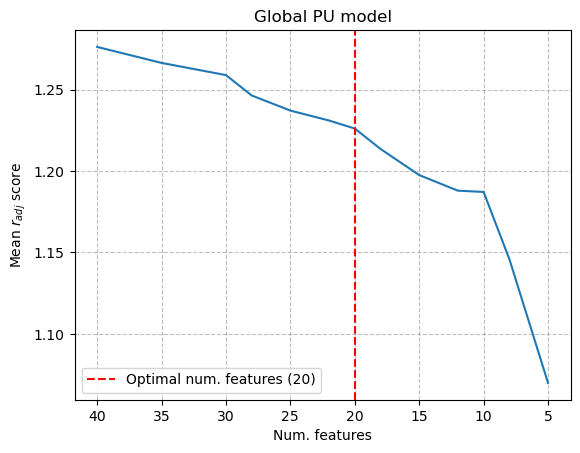

In [7]:
df_pu_search = pd.concat(
    (
        pd.DataFrame(pu_search.cv_results_["params"]),
        pd.DataFrame(
            {
                key: pu_search.cv_results_[key]
                for key in (
                    "mean_test_score",
                    "std_test_score",
                )
            }
        )
    ),
    axis="columns",
)
fig, ax = plt.subplots()
l = ax.plot(
    "featureagglomeration__n_clusters",
    "mean_test_score",
    data=df_pu_search,
    label=None,
)[0]
l.set_label(None)
ax.grid(
    linestyle="dashed",
    color="grey",
    alpha=0.5,
)
ax.set_xlim(*(ax.get_xlim()[::-1]))
ax.set_xlabel("Num. features")
ax.set_ylabel(r"Mean $r_{adj}$ score")
ax.set_title("Global PU model")

n_clusters_pu = 20
ax.axvline(
    n_clusters_pu,
    linestyle="dashed",
    color="red",
    label=f"Optimal num. features ({n_clusters_pu})",
)
ax.legend()
fig.savefig(
    os.path.join(pu_figures_dir, "cv_results.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train model with chosen number of features

In [8]:
if overwrite or (not os.path.isfile(pu_basename + ".joblib")):
    pu_best = clone(pu_search.best_estimator_)
    pu_best["featureagglomeration"].set_params(n_clusters=n_clusters_pu)
    pu_best.fit(x_pu, y_pu)
    joblib.dump(pu_best, pu_basename + ".joblib")
else:
    pu_best = joblib.load(pu_basename + ".joblib")

#### Dendrogram plot

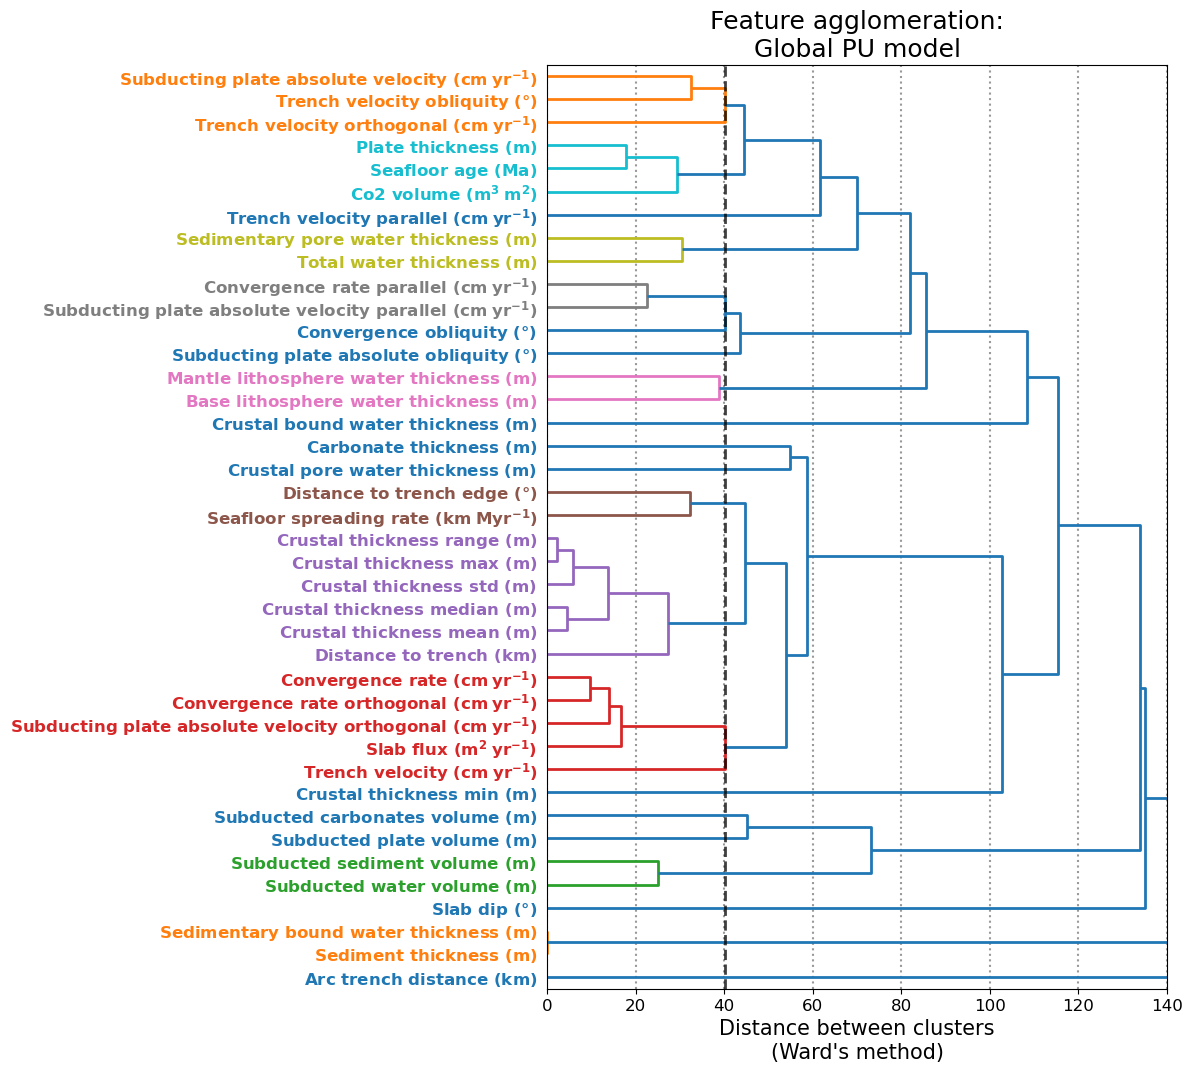

In [9]:
agg_pu = pu_best["featureagglomeration"]
dist_thresh_pu = agg_pu.distance_threshold
if dist_thresh_pu is None:
    dist_thresh_pu = distance_threshold_from_model(agg_pu)

fig, ax = plt.subplots(figsize=(8, 12))
dendro = dendrogram_from_model(
    agg_pu,
    orientation="right",
    color_threshold=dist_thresh_pu,
    labels=[format_feature_name(i, bold=True) for i in agg_pu.feature_names_in_],
).dendrogram
ax.set_xlim(0, np.quantile(agg_pu.distances_, 0.95))
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.8,
    linewidth=1.5,
    axis="x",
)
ax.axvline(
    dist_thresh_pu,
    linestyle="dashed",
    color="black",
    alpha=0.75,
    linewidth=2,
)
ax.tick_params(labelsize=12)
ax.set_title("Feature agglomeration:\nGlobal PU model", fontsize=18)
ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
for coll in ax.collections:
    coll.set_linewidth(2)
for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
    i.set_color(j)
    i.set_fontweight("bold")
fig.savefig(
    os.path.join(pu_figures_dir, "dendrogram.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [10]:
df_clusters_pu = pd.DataFrame(
    {
        "cluster": agg_pu.labels_,
        "feature": agg_pu.feature_names_in_,
    }
)
for cluster, subset in df_clusters_pu.groupby("cluster"):
    print(f"Cluster ID: {cluster}")
    for feature in sorted(subset["feature"]):
        print(f"  - {feature}")

Cluster ID: 0
  - convergence_obliquity (degrees)
  - convergence_rate_parallel (cm/yr)
  - subducting_plate_absolute_velocity_parallel (cm/yr)
Cluster ID: 1
  - convergence_rate (cm/yr)
  - convergence_rate_orthogonal (cm/yr)
  - slab_flux (m^2/yr)
  - subducting_plate_absolute_velocity_orthogonal (cm/yr)
  - trench_velocity (cm/yr)
Cluster ID: 2
  - distance_to_trench_edge (degrees)
  - seafloor_spreading_rate (km/Myr)
Cluster ID: 3
  - subducting_plate_absolute_velocity (cm/yr)
  - trench_velocity_obliquity (degrees)
  - trench_velocity_orthogonal (cm/yr)
Cluster ID: 4
  - subducted_sediment_volume (m)
  - subducted_water_volume (m)
Cluster ID: 5
  - sedimentary_pore_water_thickness (m)
  - total_water_thickness (m)
Cluster ID: 6
  - carbonate_thickness (m)
Cluster ID: 7
  - base_lithosphere_water_thickness (m)
  - mantle_lithosphere_water_thickness (m)
Cluster ID: 8
  - co2_volume (m^3/m^2)
  - plate_thickness (m)
  - seafloor_age (Ma)
Cluster ID: 9
  - subducting_plate_absolute_ob

In [11]:
print("Merged features:")
l = "-" * max([len(i) for i in df_clusters_pu["feature"]])
print(l)
for cluster, subset in df_clusters_pu.groupby("cluster"):
    if subset.shape[0] <= 1:
        continue
    for feature in sorted(subset["feature"]):
        print(feature)
    print(l)

Merged features:
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
slab_flux (m^2/yr)
subducting_plate_absolute_velocity_orthogonal (cm/yr)
trench_velocity (cm/yr)
-----------------------------------------------------
distance_to_trench_edge (degrees)
seafloor_spreading_rate (km/Myr)
-----------------------------------------------------
subducting_plate_absolute_velocity (cm/yr)
trench_velocity_obliquity (degrees)
trench_velocity_orthogonal (cm/yr)
-----------------------------------------------------
subducted_sediment_volume (m)
subducted_water_volume (m)
-----------------------------------------------------
sedimentary_pore_water_thickness (m)
total_water_thickness (m)
-----------------------------------------------------
base_lithosphere_water_thick

### By region

#### Perform cross-validation

In [12]:
pu_search_regions = {}
pu_best_regions = {}

for region, subset in combined.groupby("region"):
    region = str(region)
    if (subset["label"] == "positive").sum() < 50:
        print(f"Skipping region: {region}")
        continue
    subset = subset.drop(
        columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
        errors="ignore",
    )
    r = "_".join(region.lower().split())
    output_cv_subset = pu_cv_basename + f"_{r}.joblib"

    if (
        (not overwrite)
        and os.path.isfile(output_cv_subset)
    ):
        print(f"Loading from file: {region}")
        pu_search_regions[region] = joblib.load(output_cv_subset)
        continue

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "unlabelled"})]
    print(subset.groupby("label").size())
    x_pu_subset = subset.drop(columns="label")
    y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0})

    pu_search_subset = clone(pu_search)
    t0 = time.time()
    pu_search_subset.fit(x_pu_subset, y_pu_subset)
    joblib.dump(pu_search_subset, output_cv_subset, compress=True)
    pu_search_regions[region] = pu_search_subset
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")

    print("")

Skipping region: East Asia
Loading from file: North America


Skipping region: Other
Loading from file: South America


Loading from file: Southeast Asia


Loading from file: Tethys


#### Plot CV results

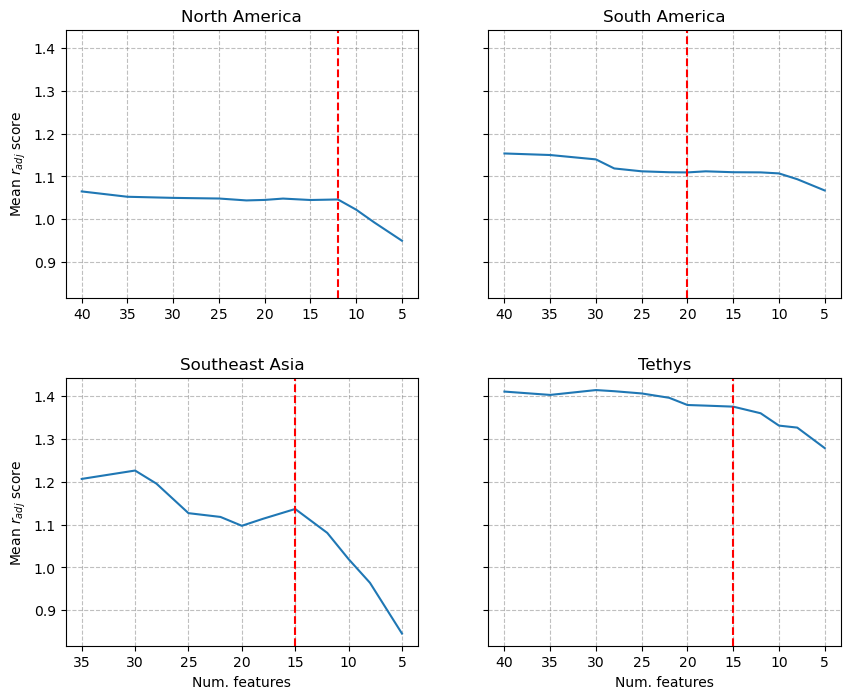

In [13]:
pu_axes = {}

fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={"hspace": 0.3}, sharey=True)
for ax, (region, pu_search_subset) in zip(np.ravel(axs), pu_search_regions.items()):
    pu_axes[region] = ax
    df_pu_subset = pd.concat(
        (
            pd.DataFrame(pu_search_subset.cv_results_["params"]),
            pd.DataFrame(
                {
                    key: pu_search_subset.cv_results_[key]
                    for key in (
                        "mean_test_score",
                        "std_test_score",
                    )
                }
            )
        ),
        axis="columns",
    )
    l = ax.plot(
        "featureagglomeration__n_clusters",
        "mean_test_score",
        data=df_pu_subset,
    )[0]
    l.set_label(None)

    ax.grid(
        linestyle="dashed",
        color="grey",
        alpha=0.5,
    )
    ax.set_xlim(*(ax.get_xlim()[::-1]))
    ax.set_title(region)

n_clusters_pu_regions = {
    "North America": 12,
    "South America": 20,
    "Southeast Asia": 15,
    "Tethys": 15,
}
for region, n_clusters_region in n_clusters_pu_regions.items():
    ax = pu_axes[region]
    ax.axvline(
        n_clusters_region,
        linestyle="dashed",
        color="red",
        label="Optimal num. features",
    )

for ax in axs[:, 0]:
    ax.set_ylabel(r"Mean $r_{adj}$ score")
for ax in axs[-1, :]:
    ax.set_xlabel("Num. features")
fig.savefig(
    os.path.join(pu_figures_dir, "cv_results_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train models with chosen numbers of features

In [14]:
for region, n_clusters_region in n_clusters_pu_regions.items():
    r = "_".join(region.lower().split())
    output_subset = pu_basename + f"_{r}.joblib"

    if overwrite or (not os.path.isfile(output_subset)):
        subset_best = clone(pu_search_regions[region].best_estimator_)
        subset_best["featureagglomeration"].set_params(n_clusters=n_clusters_region)
        subset = combined[combined["region"] == region]
        subset = subset.drop(
            columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
            errors="ignore",
        )
        subset = subset[subset["label"].isin({"positive", "unlabelled"})]
        x_pu_subset = subset.drop(columns="label")
        y_pu_subset = subset["label"].replace({"positive": 1, "unlabelled": 0})
        subset_best.fit(x_pu_subset, y_pu_subset)
        pu_best_regions[region] = subset_best
        joblib.dump(subset_best, output_subset, compress=True)
    else:
        pu_best_regions[region] = joblib.load(output_subset)

#### Dendrogram plots

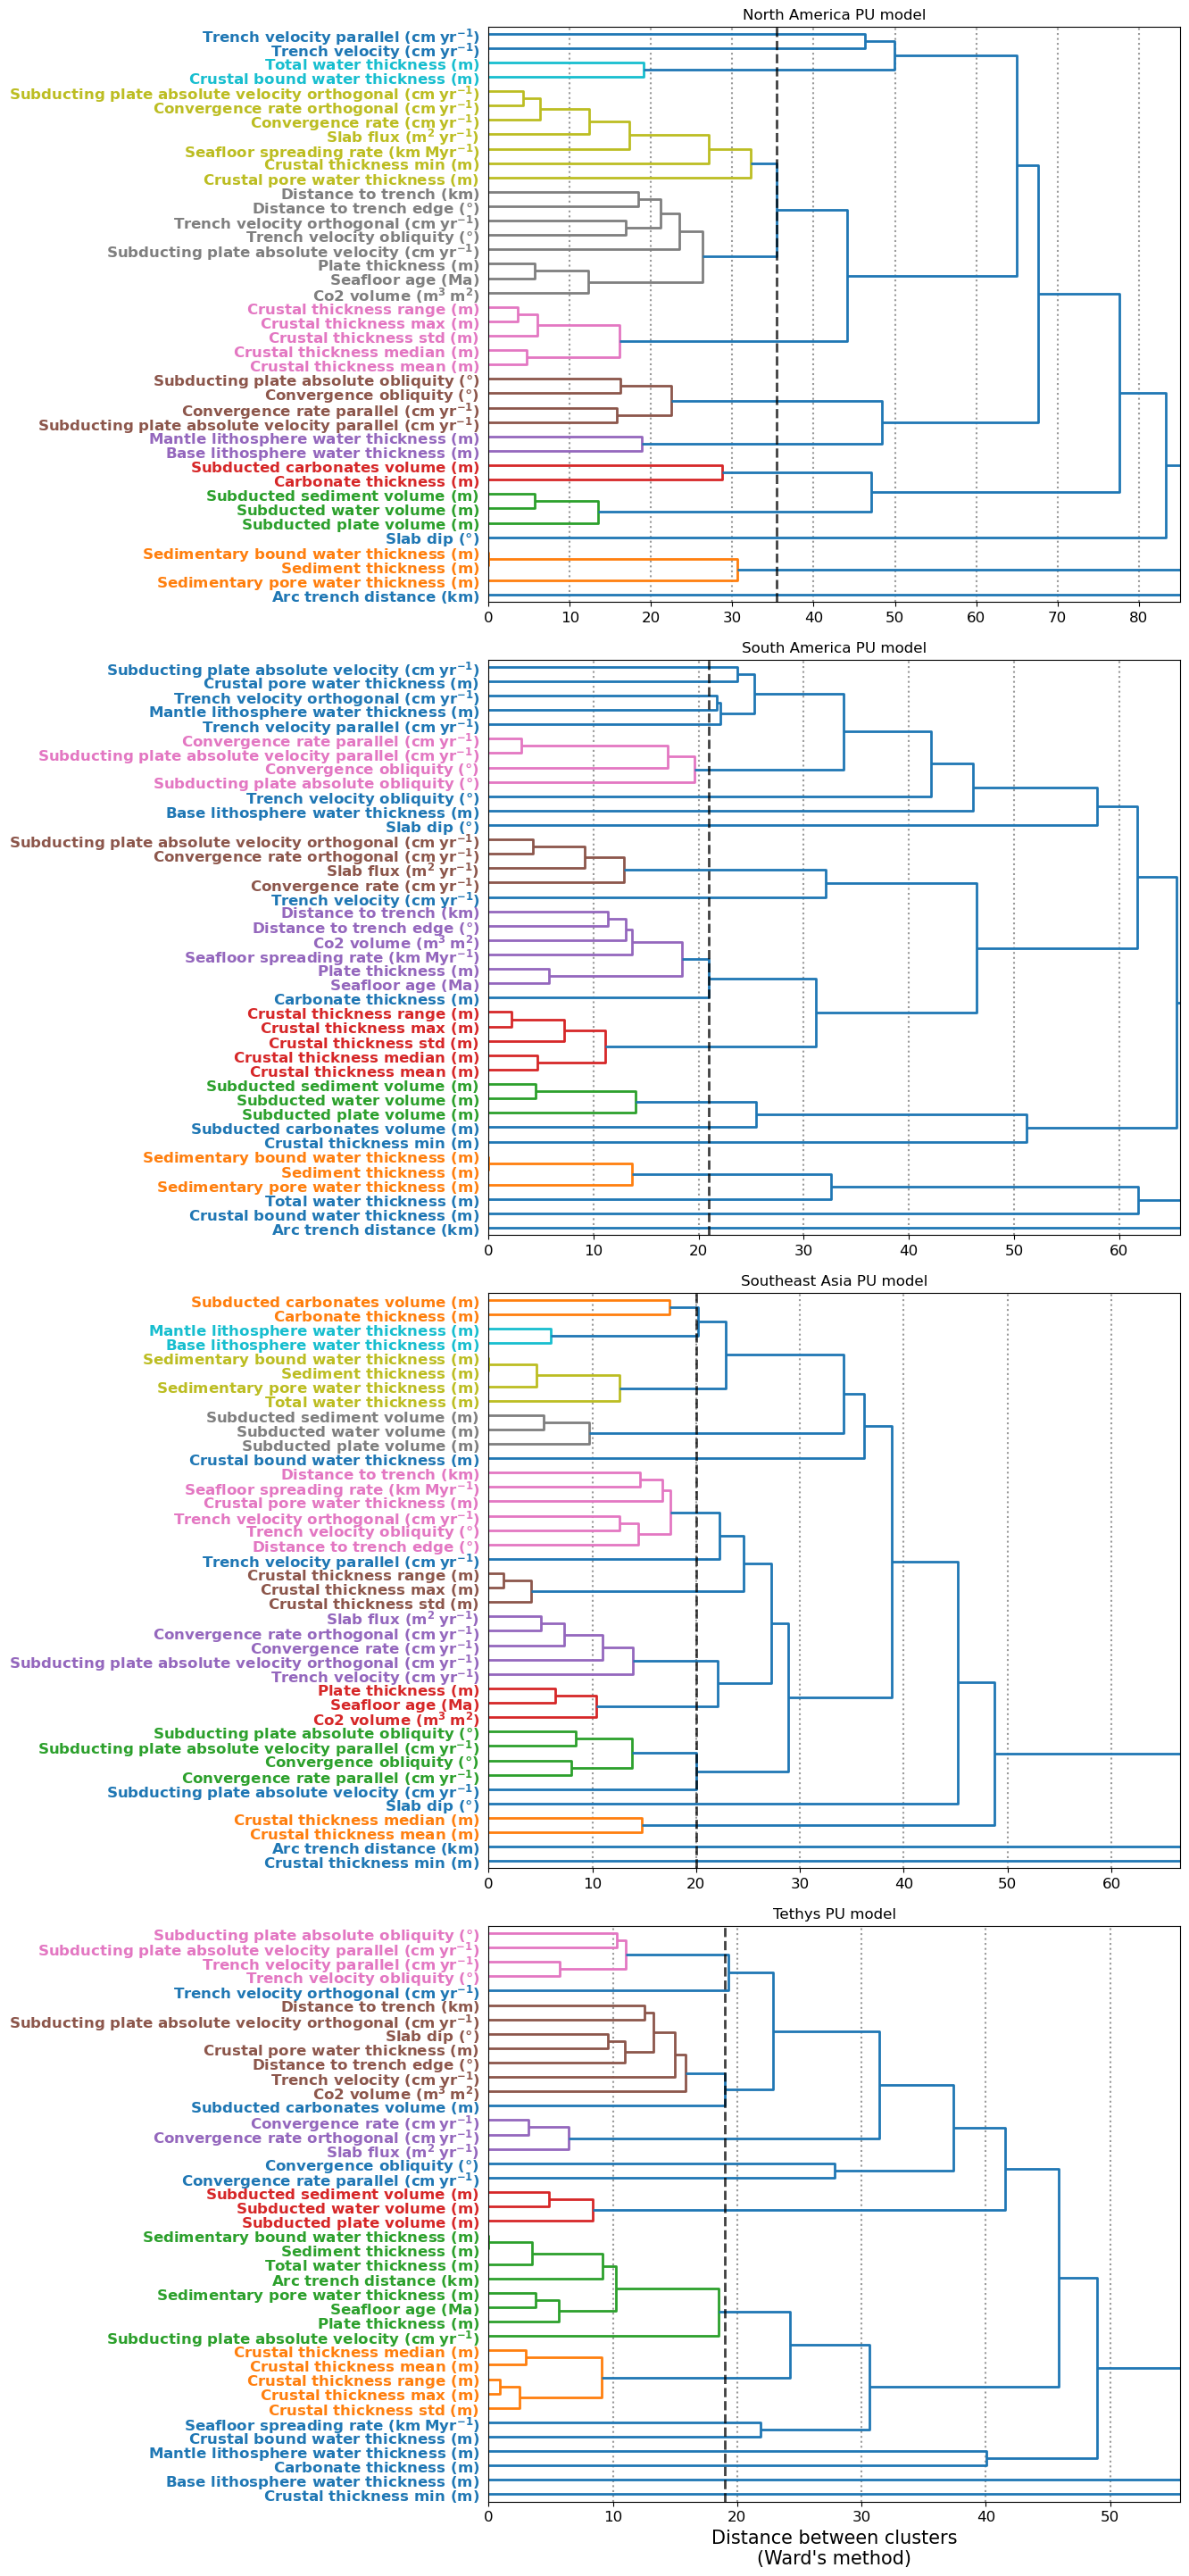

In [15]:
nrows = len(pu_best_regions)
fig, axs = plt.subplots(
    nrows,
    figsize=(10, 9 * nrows),
    gridspec_kw={"hspace": 0.1},
    squeeze=False,
)

for (region, pu_best_region), ax in zip(pu_best_regions.items(), np.ravel(axs)):
    agg_pu_region = pu_best_region["featureagglomeration"]
    dist_thresh_pu_region = agg_pu_region.distance_threshold
    if dist_thresh_pu_region is None:
        dist_thresh_pu_region = distance_threshold_from_model(agg_pu_region)

    dendro = dendrogram_from_model(
        agg_pu_region,
        orientation="right",
        color_threshold=dist_thresh_pu_region,
        ax=ax,
        labels=[format_feature_name(i, bold=True) for i in agg_pu_region.feature_names_in_],
    ).dendrogram
    ax.set_xlim(0, np.quantile(agg_pu_region.distances_, 0.95))
    ax.grid(
        linestyle="dotted",
        color="grey",
        alpha=0.8,
        linewidth=1.5,
        axis="x",
    )
    ax.axvline(
        dist_thresh_pu_region,
        linestyle="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    ax.tick_params(labelsize=12)
    ax.set_title(f"{region} PU model")
    for coll in ax.collections:
        coll.set_linewidth(2)
    for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
        i.set_color(j)
        i.set_fontweight("bold")
for ax in axs[-1, :]:
    ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
fig.savefig(
    os.path.join(pu_figures_dir, "dendrograms_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [16]:
for region, pu_best_region in pu_best_regions.items():
    agg_pu_region = pu_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_pu_region.labels_,
            "feature": agg_pu_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    for cluster, subset in df_clusters_region.groupby("cluster"):
        print(f"Cluster ID: {cluster}")
        for feature in sorted(subset["feature"]):
            print(f"  - {feature}")
    print("\n")

North America:
Cluster ID: 0
  - co2_volume (m^3/m^2)
  - convergence_rate (cm/yr)
  - convergence_rate_orthogonal (cm/yr)
  - crustal_pore_water_thickness (m)
  - crustal_thickness_min (m)
  - distance_to_trench (km)
  - distance_to_trench_edge (degrees)
  - plate_thickness (m)
  - seafloor_age (Ma)
  - seafloor_spreading_rate (km/Myr)
  - slab_flux (m^2/yr)
  - subducting_plate_absolute_velocity (cm/yr)
  - subducting_plate_absolute_velocity_orthogonal (cm/yr)
  - trench_velocity_obliquity (degrees)
  - trench_velocity_orthogonal (cm/yr)
Cluster ID: 1
  - convergence_obliquity (degrees)
  - convergence_rate_parallel (cm/yr)
  - subducting_plate_absolute_obliquity (degrees)
  - subducting_plate_absolute_velocity_parallel (cm/yr)
Cluster ID: 2
  - sediment_thickness (m)
  - sedimentary_bound_water_thickness (m)
  - sedimentary_pore_water_thickness (m)
Cluster ID: 3
  - crustal_bound_water_thickness (m)
  - total_water_thickness (m)
Cluster ID: 4
  - subducted_plate_volume (m)
  - subdu

In [17]:
for region, pu_best_region in pu_best_regions.items():
    agg_pu_region = pu_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_pu_region.labels_,
            "feature": agg_pu_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    print("Merged features:")
    l = "-" * max([len(i) for i in df_clusters_region["feature"]])
    print(l)
    for cluster, subset in df_clusters_region.groupby("cluster"):
        if subset.shape[0] <= 1:
            continue
        for feature in sorted(subset["feature"]):
            print(feature)
        print(l)
    print("\n")

North America:
Merged features:
-----------------------------------------------------
co2_volume (m^3/m^2)
convergence_rate (cm/yr)
convergence_rate_orthogonal (cm/yr)
crustal_pore_water_thickness (m)
crustal_thickness_min (m)
distance_to_trench (km)
distance_to_trench_edge (degrees)
plate_thickness (m)
seafloor_age (Ma)
seafloor_spreading_rate (km/Myr)
slab_flux (m^2/yr)
subducting_plate_absolute_velocity (cm/yr)
subducting_plate_absolute_velocity_orthogonal (cm/yr)
trench_velocity_obliquity (degrees)
trench_velocity_orthogonal (cm/yr)
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_obliquity (degrees)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
sediment_thickness (m)
sedimentary_bound_water_thickness (m)
sedimentary_pore_water_thickness (m)
-----------------------------------------------------
crustal_bound_water_thickness (m)

## Train the SVM models

### Global

#### Perform cross-validation

In [18]:
# Wrangle training data
train_svm = cleaned[cleaned["label"].isin({"positive", "negative"})]
x_svm = train_svm.drop(columns="label")
y_svm = train_svm["label"].replace({"positive": 1, "negative": 0})

if overwrite or not os.path.isfile(svm_cv_basename + ".joblib"):
    svm_model = SVC(**svm_params)
    svm_pipeline = make_pipeline(
        *(clone(preprocessing)),
        svm_model,
    )
    svm_pipeline.set_output(transform="pandas")
    svm_search = GridSearchCV(
        svm_pipeline,
        param_grid=param_grid,
        n_jobs=n_jobs,
        refit=True,
        cv=cv,
        verbose=verbose,
        scoring="f1",
        return_train_score=False,
    )

    # Train model
    t0 = time.time()
    svm_search.fit(x_svm, y_svm)

    # Save to file
    joblib.dump(svm_search, svm_cv_basename + ".joblib", compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")
else:
    svm_search = joblib.load(svm_cv_basename + ".joblib")

#### Plot CV results

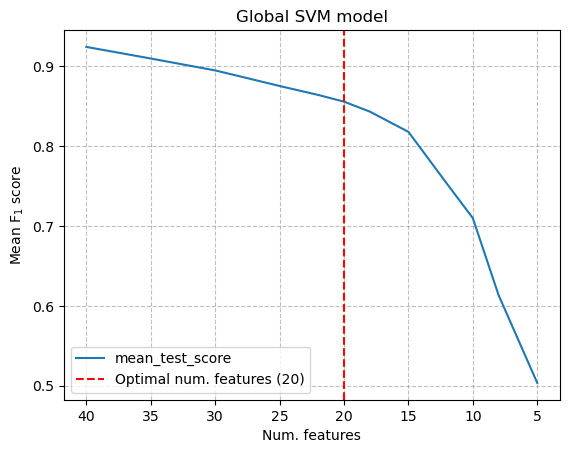

In [19]:
df_svm_search = pd.concat(
    (
        pd.DataFrame(svm_search.cv_results_["params"]),
        pd.DataFrame(
            {
                key: svm_search.cv_results_[key]
                for key in (
                    "mean_test_score",
                    "std_test_score",
                )
            }
        )
    ),
    axis="columns",
)
fig, ax = plt.subplots()
ax.plot(
    "featureagglomeration__n_clusters",
    "mean_test_score",
    data=df_svm_search,
)
ax.grid(
    linestyle="dashed",
    color="grey",
    alpha=0.5,
)
ax.set_xlim(*(ax.get_xlim()[::-1]))
ax.set_xlabel("Num. features")
ax.set_ylabel(r"Mean $\mathrm{F_1}$ score")
ax.set_title("Global SVM model")

n_clusters_svm = 20
ax.axvline(
    n_clusters_svm,
    linestyle="dashed",
    color="red",
    label=f"Optimal num. features ({n_clusters_svm})",
)
ax.legend()
fig.savefig(
    os.path.join(svm_figures_dir, "cv_results.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train model with chosen number of features

In [20]:
if overwrite or (not os.path.isfile(svm_basename + ".joblib")):
    svm_best = clone(svm_search.best_estimator_)
    svm_best["featureagglomeration"].set_params(n_clusters=n_clusters_svm)
    svm_best.fit(x_svm, y_svm)
    joblib.dump(svm_best, svm_basename + ".joblib")
else:
    svm_best = joblib.load(svm_basename + ".joblib")

#### Dendrogram plot

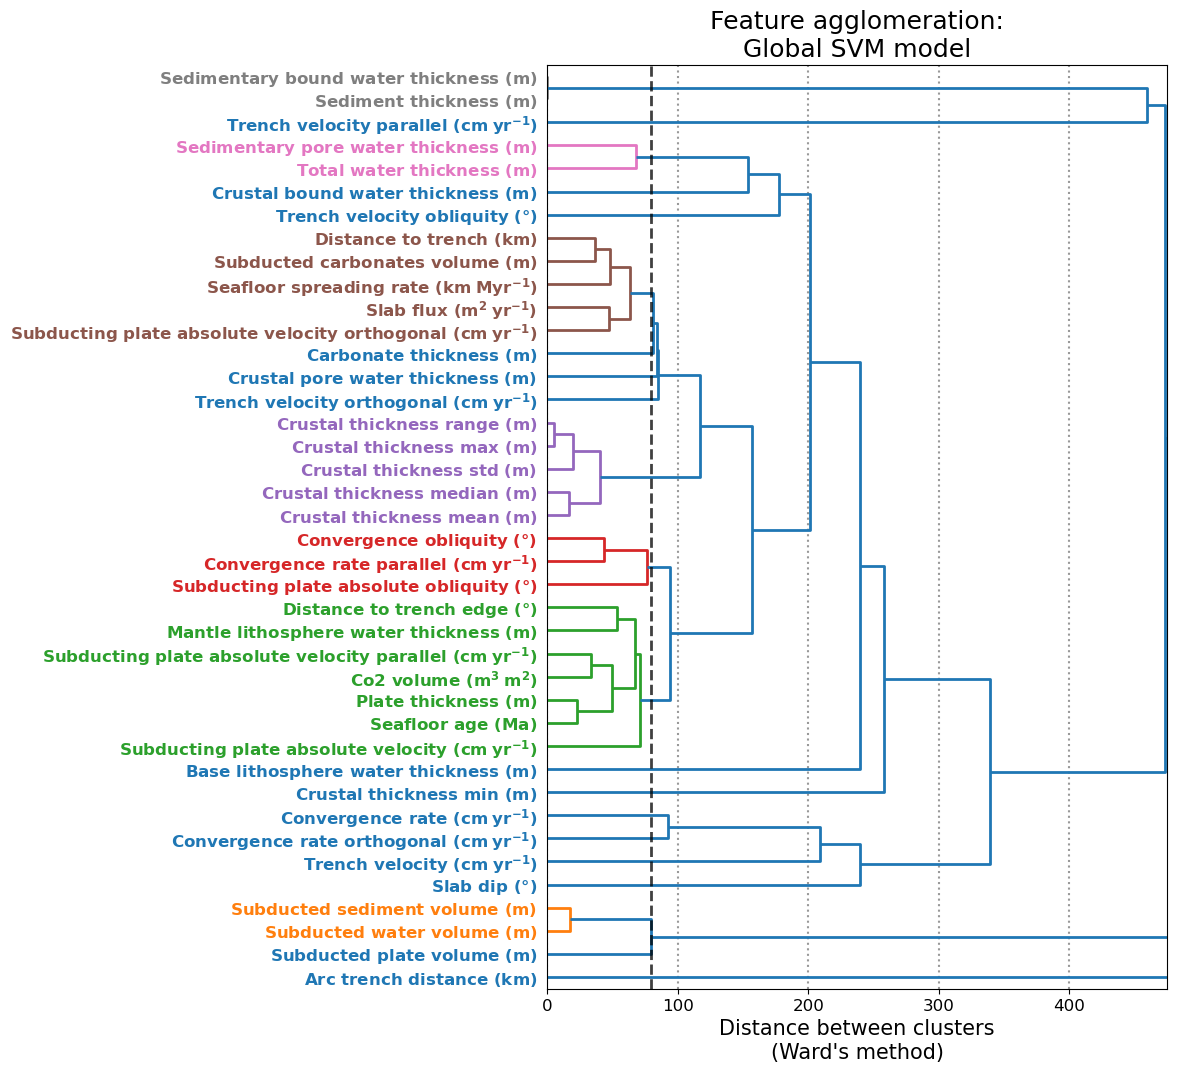

In [21]:
agg_svm = svm_best["featureagglomeration"]
dist_thresh_svm = agg_svm.distance_threshold
if dist_thresh_svm is None:
    dist_thresh_svm = distance_threshold_from_model(agg_svm)

fig, ax = plt.subplots(figsize=(8, 12))
dendro = dendrogram_from_model(
    agg_svm,
    orientation="right",
    color_threshold=dist_thresh_svm,
    labels=[format_feature_name(i, bold=True) for i in agg_svm.feature_names_in_],
).dendrogram
ax.set_xlim(0, np.quantile(agg_svm.distances_, 0.95))
ax.grid(
    linestyle="dotted",
    color="grey",
    alpha=0.8,
    linewidth=1.5,
    axis="x",
)
ax.axvline(
    dist_thresh_svm,
    linestyle="dashed",
    color="black",
    alpha=0.75,
    linewidth=2,
)
ax.tick_params(labelsize=12)
ax.set_title("Feature agglomeration:\nGlobal SVM model", fontsize=18)
ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
for coll in ax.collections:
    coll.set_linewidth(2)
for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
    i.set_color(j)
    i.set_fontweight("bold")
fig.savefig(
    os.path.join(svm_figures_dir, "dendrogram.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [22]:
df_clusters_svm = pd.DataFrame(
    {
        "cluster": agg_svm.labels_,
        "feature": agg_svm.feature_names_in_,
    }
)
for cluster, subset in df_clusters_svm.groupby("cluster"):
    print(f"Cluster ID: {cluster}")
    for feature in sorted(subset["feature"]):
        print(f"  - {feature}")

Cluster ID: 0
  - subducted_plate_volume (m)
  - subducted_sediment_volume (m)
  - subducted_water_volume (m)
Cluster ID: 1
  - co2_volume (m^3/m^2)
  - distance_to_trench_edge (degrees)
  - mantle_lithosphere_water_thickness (m)
  - plate_thickness (m)
  - seafloor_age (Ma)
  - subducting_plate_absolute_velocity (cm/yr)
  - subducting_plate_absolute_velocity_parallel (cm/yr)
Cluster ID: 2
  - convergence_obliquity (degrees)
  - convergence_rate_parallel (cm/yr)
  - subducting_plate_absolute_obliquity (degrees)
Cluster ID: 3
  - sedimentary_pore_water_thickness (m)
  - total_water_thickness (m)
Cluster ID: 4
  - sediment_thickness (m)
  - sedimentary_bound_water_thickness (m)
Cluster ID: 5
  - distance_to_trench (km)
  - seafloor_spreading_rate (km/Myr)
  - slab_flux (m^2/yr)
  - subducted_carbonates_volume (m)
  - subducting_plate_absolute_velocity_orthogonal (cm/yr)
Cluster ID: 6
  - crustal_thickness_max (m)
  - crustal_thickness_mean (m)
  - crustal_thickness_median (m)
  - crustal

In [23]:
print("Merged features:")
l = "-" * max([len(i) for i in df_clusters_svm["feature"]])
print(l)
for cluster, subset in df_clusters_svm.groupby("cluster"):
    if subset.shape[0] <= 1:
        continue
    for feature in sorted(subset["feature"]):
        print(feature)
    print(l)

Merged features:
-----------------------------------------------------
subducted_plate_volume (m)
subducted_sediment_volume (m)
subducted_water_volume (m)
-----------------------------------------------------
co2_volume (m^3/m^2)
distance_to_trench_edge (degrees)
mantle_lithosphere_water_thickness (m)
plate_thickness (m)
seafloor_age (Ma)
subducting_plate_absolute_velocity (cm/yr)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_obliquity (degrees)
-----------------------------------------------------
sedimentary_pore_water_thickness (m)
total_water_thickness (m)
-----------------------------------------------------
sediment_thickness (m)
sedimentary_bound_water_thickness (m)
-----------------------------------------------------
distance_to_trench (km)
seafloor_spreading_rate (km/Myr)
slab_flux (m^2/yr)
subducted_carbonates_volume (m)
subd

### By region

#### Perform cross-validation

In [24]:
svm_search_regions = {}
svm_best_regions = {}

for region, subset in combined.groupby("region"):
    region = str(region)
    if (
        (subset["label"] == "positive").sum() < 25
        or (subset["label"] == "negative").sum() < 25
    ):
        print(f"Skipping region: {region}")
        print("")
        continue
    r = "_".join(region.lower().split())
    output_cv_subset = svm_cv_basename + f"_{r}.joblib"

    if (not overwrite) and os.path.isfile(output_cv_subset):
        print(f"Loading from file: {region}")
        svm_search_regions[region] = joblib.load(output_cv_subset)
        continue

    print(f"Region: {region}")
    subset = subset[subset["label"].isin({"positive", "negative"})]
    print(subset.groupby("label").size())
    x_svm_subset = subset[cleaned.columns].drop(columns="label")
    y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0})

    svm_search_subset = clone(svm_search)
    t0 = time.time()
    svm_search_subset.fit(x_svm_subset, y_svm_subset)
    joblib.dump(svm_search_subset, output_cv_subset, compress=True)
    duration = timedelta(seconds=time.time() - t0)
    print(f"Cross-validation time: {duration}")

    print("")

Skipping region: East Asia

Loading from file: North America
Skipping region: Other

Loading from file: South America


Skipping region: Southeast Asia

Skipping region: Tethys



#### Plot CV results

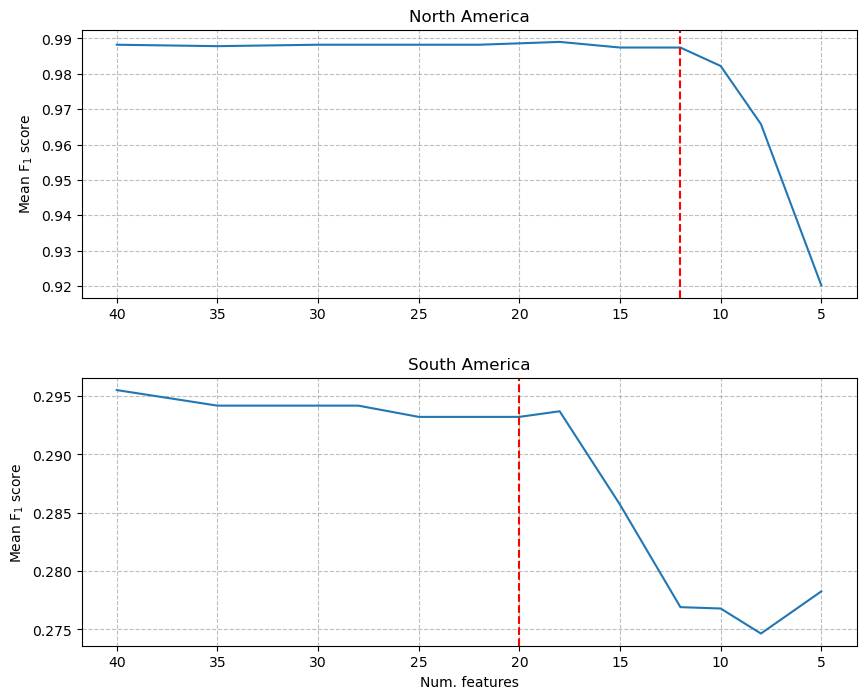

In [25]:
svm_axes = {}

fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"hspace": 0.3}, squeeze=False)
for ax, (region, svm_search_subset) in zip(np.ravel(axs), svm_search_regions.items()):
    svm_axes[region] = ax
    df_svm_subset = pd.concat(
        (
            pd.DataFrame(svm_search_subset.cv_results_["params"]),
            pd.DataFrame(
                {
                    key: svm_search_subset.cv_results_[key]
                    for key in (
                        "mean_test_score",
                        "std_test_score",
                    )
                }
            )
        ),
        axis="columns",
    )
    l = ax.plot(
        "featureagglomeration__n_clusters",
        "mean_test_score",
        data=df_svm_subset,
    )[0]
    l.set_label(None)

    ax.grid(
        linestyle="dashed",
        color="grey",
        alpha=0.5,
    )
    ax.set_xlim(*(ax.get_xlim()[::-1]))
    ax.set_title(region)

n_clusters_svm_regions = {
    "North America": 12,
    "South America": 20,
}
for region, n_clusters_region in n_clusters_svm_regions.items():
    ax = svm_axes[region]
    ax.axvline(
        n_clusters_region,
        linestyle="dashed",
        color="red",
        label="Optimal num. features",
    )

for ax in axs[:, 0]:
    ax.set_ylabel(r"Mean $\mathrm{F_1}$ score")
for ax in axs[-1, :]:
    ax.set_xlabel("Num. features")
fig.savefig(
    os.path.join(svm_figures_dir, "cv_results_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Train models with chosen numbers of features

In [26]:
for region, n_clusters_region in n_clusters_svm_regions.items():
    r = "_".join(region.lower().split())
    output_subset = svm_basename + f"_{r}.joblib"

    if overwrite or (not os.path.isfile(output_subset)):
        subset_best = clone(svm_search_regions[region].best_estimator_)
        subset_best["featureagglomeration"].set_params(n_clusters=n_clusters_region)
        subset = combined[combined["region"] == region]
        subset = subset.drop(
            columns=list(COLUMNS_TO_DROP | PRESERVATION_COLUMNS),
            errors="ignore",
        )
        subset = subset[subset["label"].isin({"positive", "negative"})]
        x_svm_subset = subset.drop(columns="label")
        y_svm_subset = subset["label"].replace({"positive": 1, "negative": 0})
        subset_best.fit(x_svm_subset, y_svm_subset)
        svm_best_regions[region] = subset_best
        joblib.dump(subset_best, output_subset, compress=True)
    else:
        svm_best_regions[region] = joblib.load(output_subset)

#### Dendogram plots

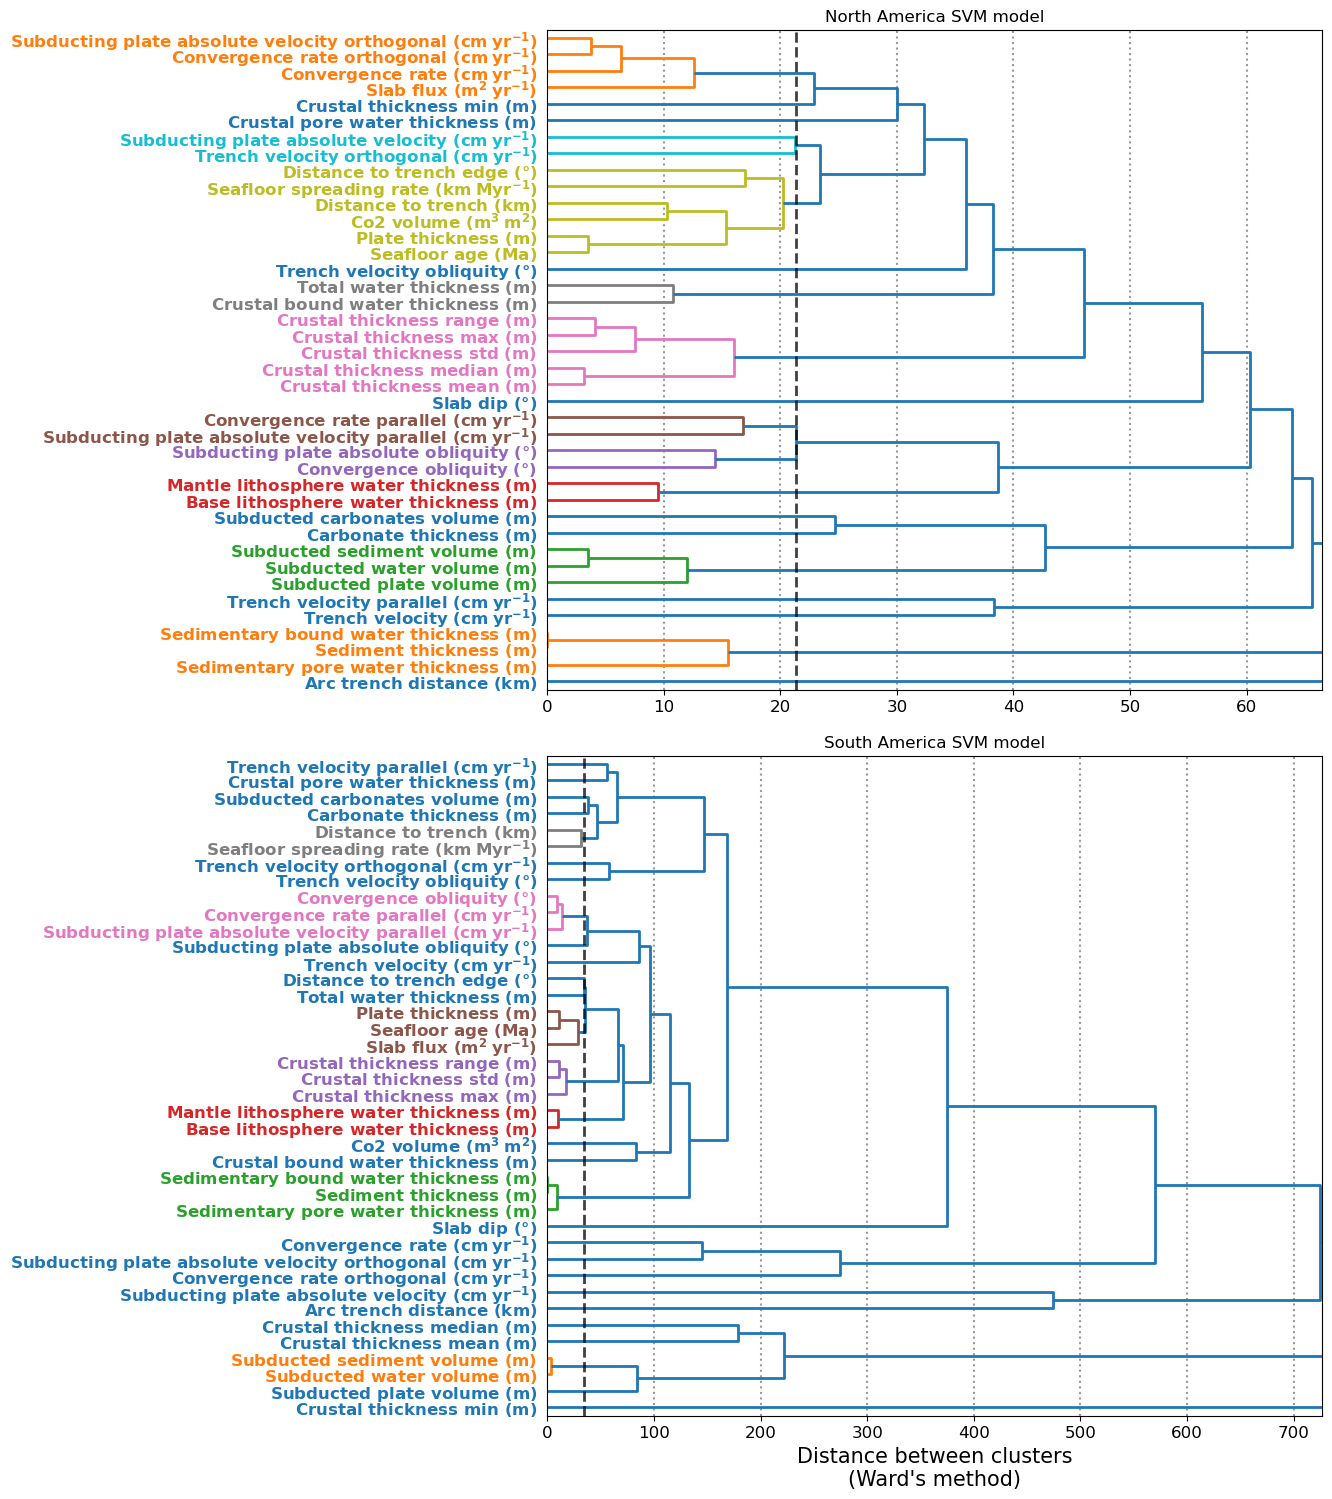

In [27]:
nrows = len(svm_best_regions)
fig, axs = plt.subplots(
    nrows,
    figsize=(10, 9 * nrows),
    gridspec_kw={"hspace": 0.1},
    squeeze=False,
)

for (region, svm_best_region), ax in zip(svm_best_regions.items(), np.ravel(axs)):
    agg_svm_region = svm_best_region["featureagglomeration"]
    dist_thresh_svm_region = agg_svm_region.distance_threshold
    if dist_thresh_svm_region is None:
        dist_thresh_svm_region = distance_threshold_from_model(agg_svm_region)

    dendro = dendrogram_from_model(
        agg_svm_region,
        orientation="right",
        color_threshold=dist_thresh_svm_region,
        ax=ax,
        labels=[format_feature_name(i, bold=True) for i in agg_svm_region.feature_names_in_],
    ).dendrogram
    ax.set_xlim(0, np.quantile(agg_svm_region.distances_, 0.95))
    ax.grid(
        linestyle="dotted",
        color="grey",
        alpha=0.8,
        linewidth=1.5,
        axis="x",
    )
    ax.axvline(
        dist_thresh_svm_region,
        linestyle="dashed",
        color="black",
        alpha=0.75,
        linewidth=2,
    )
    ax.tick_params(labelsize=12)
    ax.set_title(f"{region} SVM model")
    for coll in ax.collections:
        coll.set_linewidth(2)
    for i, j in zip(ax.get_ymajorticklabels(), dendro["leaves_color_list"]):
        i.set_color(j)
        i.set_fontweight("bold")
for ax in axs[-1, :]:
    ax.set_xlabel("Distance between clusters\n(Ward's method)", fontsize=15)
fig.savefig(
    os.path.join(svm_figures_dir, "dendrograms_regions.png"),
    dpi=350,
    bbox_inches="tight",
)

#### Merged features

In [28]:
for region, svm_best_region in svm_best_regions.items():
    agg_svm_region = svm_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_svm_region.labels_,
            "feature": agg_svm_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    for cluster, subset in df_clusters_region.groupby("cluster"):
        print(f"Cluster ID: {cluster}")
        for feature in sorted(subset["feature"]):
            print(f"  - {feature}")
    print("\n")

North America:
Cluster ID: 0
  - convergence_obliquity (degrees)
  - convergence_rate_parallel (cm/yr)
  - subducting_plate_absolute_obliquity (degrees)
  - subducting_plate_absolute_velocity_parallel (cm/yr)
Cluster ID: 1
  - co2_volume (m^3/m^2)
  - distance_to_trench (km)
  - distance_to_trench_edge (degrees)
  - plate_thickness (m)
  - seafloor_age (Ma)
  - seafloor_spreading_rate (km/Myr)
Cluster ID: 2
  - subducting_plate_absolute_velocity (cm/yr)
  - trench_velocity_orthogonal (cm/yr)
Cluster ID: 3
  - crustal_thickness_max (m)
  - crustal_thickness_mean (m)
  - crustal_thickness_median (m)
  - crustal_thickness_range (m)
  - crustal_thickness_std (m)
Cluster ID: 4
  - base_lithosphere_water_thickness (m)
  - mantle_lithosphere_water_thickness (m)
Cluster ID: 5
  - sediment_thickness (m)
  - sedimentary_bound_water_thickness (m)
  - sedimentary_pore_water_thickness (m)
Cluster ID: 6
  - subducted_carbonates_volume (m)
Cluster ID: 7
  - convergence_rate (cm/yr)
  - convergence_ra

In [29]:
for region, svm_best_region in svm_best_regions.items():
    agg_svm_region = svm_best_region["featureagglomeration"]
    df_clusters_region = pd.DataFrame(
        {
            "cluster": agg_svm_region.labels_,
            "feature": agg_svm_region.feature_names_in_,
        }
    )
    print(f"{region}:")
    print("Merged features:")
    l = "-" * max([len(i) for i in df_clusters_region["feature"]])
    print(l)
    for cluster, subset in df_clusters_region.groupby("cluster"):
        if subset.shape[0] <= 1:
            continue
        for feature in sorted(subset["feature"]):
            print(feature)
        print(l)
    print("\n")

North America:
Merged features:
-----------------------------------------------------
convergence_obliquity (degrees)
convergence_rate_parallel (cm/yr)
subducting_plate_absolute_obliquity (degrees)
subducting_plate_absolute_velocity_parallel (cm/yr)
-----------------------------------------------------
co2_volume (m^3/m^2)
distance_to_trench (km)
distance_to_trench_edge (degrees)
plate_thickness (m)
seafloor_age (Ma)
seafloor_spreading_rate (km/Myr)
-----------------------------------------------------
subducting_plate_absolute_velocity (cm/yr)
trench_velocity_orthogonal (cm/yr)
-----------------------------------------------------
crustal_thickness_max (m)
crustal_thickness_mean (m)
crustal_thickness_median (m)
crustal_thickness_range (m)
crustal_thickness_std (m)
-----------------------------------------------------
base_lithosphere_water_thickness (m)
mantle_lithosphere_water_thickness (m)
-----------------------------------------------------
sediment_thickness (m)
sedimentary_bound